In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

In [3]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
#                     format='basic', delimiter='\s')
parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


# r13
r13 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
# kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [4]:
parsec.columns

ColDefs(
    name = 'Zini'; format = 'D'
    name = 'MH'; format = 'D'
    name = 'logAge'; format = 'D'
    name = 'Mini'; format = 'D'
    name = 'int_IMF'; format = 'D'
    name = 'Mass'; format = 'D'
    name = 'logL'; format = 'D'
    name = 'logTe'; format = 'D'
    name = 'logg'; format = 'D'
    name = 'label'; format = 'K'
    name = 'McoreTP'; format = 'D'
    name = 'C_O'; format = 'D'
    name = 'period0'; format = 'D'
    name = 'period1'; format = 'D'
    name = 'period2'; format = 'D'
    name = 'period3'; format = 'D'
    name = 'period4'; format = 'D'
    name = 'pmode'; format = 'K'
    name = 'Mloss'; format = 'D'
    name = 'tau1m'; format = 'D'
    name = 'X'; format = 'D'
    name = 'Y'; format = 'D'
    name = 'Xc'; format = 'D'
    name = 'Xn'; format = 'D'
    name = 'Xo'; format = 'D'
    name = 'Cexcess'; format = 'D'
    name = 'Z'; format = 'D'
    name = 'mbolmag'; format = 'D'
    name = 'Jmag'; format = 'D'
    name = 'Hmag'; format = 'D'
    name = 'Ksm

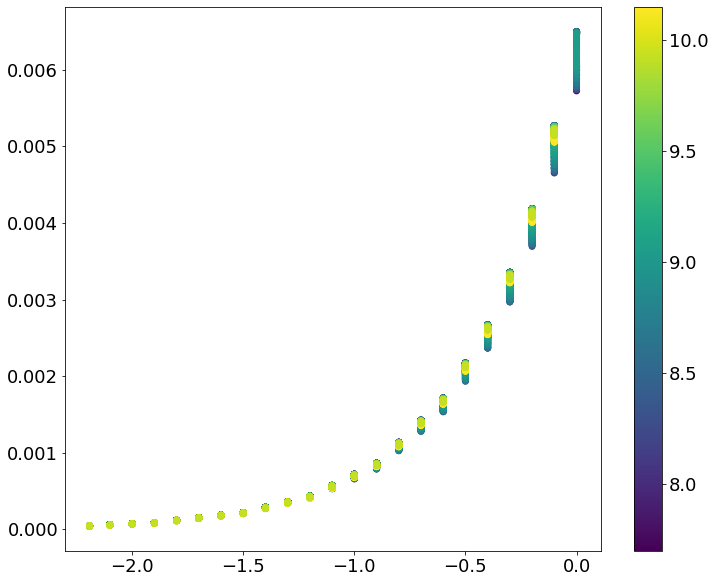

In [5]:
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['Xo'],c=parsec['logAge'])
plt.colorbar()

In [6]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

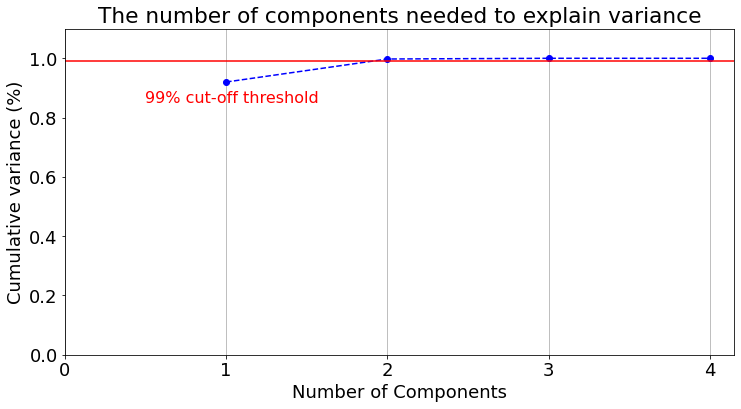

In [8]:
### Setup 
data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

### Determine Number of factors
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [10]:
### Find all models

#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
predict = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

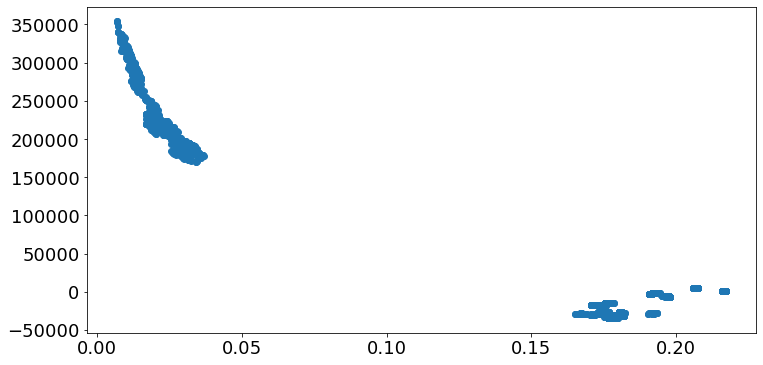

In [11]:
plt.scatter(mads,ll)

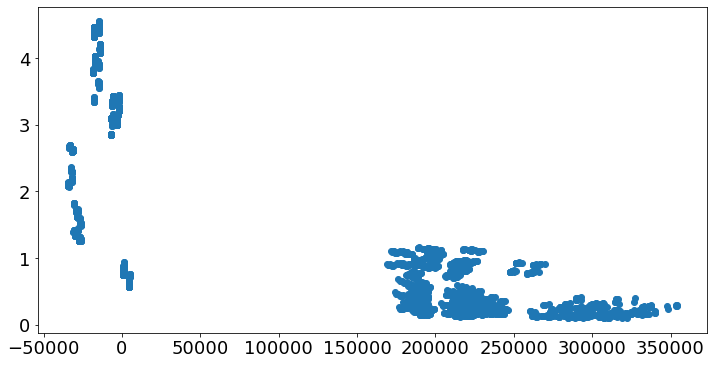

In [12]:
plt.scatter(ll,max_resid)

In [11]:
# models_str[np.asarray(max_resid).argmin()]

In [13]:
models_str[np.asarray(mads).argmin()]

array(['x1', 'x2', 'x3', 'x12', 'x13', 'x23', 'x1sq', 'x2sq', 'x3sq',
       'x1cu', 'x2cu'], dtype='<U4')

In [36]:
print(summaries[np.asarray(ll).argmax()])
models_str[np.asarray(ll).argmax()]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.067e+06
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:55:52   Log-Likelihood:             3.5390e+05
No. Observations:              118040   AIC:                        -7.078e+05
Df Residuals:                  118027   BIC:                        -7.076e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8090   6.78e-05   1.45e+05      0.0

array(['x1', 'x2', 'x3', 'x12', 'x13', 'x23', 'x1sq', 'x2sq', 'x3sq',
       'x1cu', 'x2cu', 'x3cu'], dtype='<U4')

In [14]:
models_str[np.asarray(max_resid).argmin()]

array(['x1', 'x2', 'x3', 'x12', 'x1sq', 'x2sq', 'x3sq', 'x1cu', 'x2cu',
       'x3cu'], dtype='<U4')

In [11]:
parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
print(afunc.mad(parsimonious_residual))
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))
# print(models_str[np.asarray(ll).argmax()])

0.00693128957256306
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.687e+06
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:02:55   Log-Likelihood:             3.5373e+05
No. Observations:              118040   AIC:                        -7.074e+05
Df Residuals:                  118028   BIC:                        -7.073e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8090   6.78e-05

In [26]:
# [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,1.09839708e-01,
# -5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]==[9.38559303e+00,4.50640684e-02,-6.04245546e-02,
# -2.97525149e+00,1.89919586e-02,-5.42190398e-02,1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,
# 2.28289124e-02]

# [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,1.10591414e-01,
# -5.87621144e-03,2.69613674e-02,8.71979746e-01] == [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,
# 1.89942809e-02 -5.40460673e-02,1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]

In [12]:
def find_ages(z1,z2,z3):
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
#     p = [9.80896282e+00,-4.65080541e-03,2.72682487e-02,-3.23531502e+00,2.22256767e-02,4.53706896e-02,
#          -8.80208834e-02,-7.28411958e-03,3.80042306e-02,8.48943269e-01,-3.56646067e-02,2.32900165e-02]
    p = [9.80896282e+00,-4.65080541e-03,2.72682487e-02,-3.23531502e+00,2.22256767e-02,4.53706896e-02,
         -8.80208834e-02,-7.28411958e-03,3.80042306e-02,8.48943269e-01,-3.56646067e-02,2.32900165e-02]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    return age


<font size='48'>
    <b>
        CALCULATE AGES
    </b>
</font>

In [13]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [14]:
age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [15]:
# print(np.where(parages<=np.log10(0.5*10**9)))
# print(np.log10(0.5*10**9))
# plt.hist(parages,range=(8,12))

Text(0, 0.5, 'Bayesian')

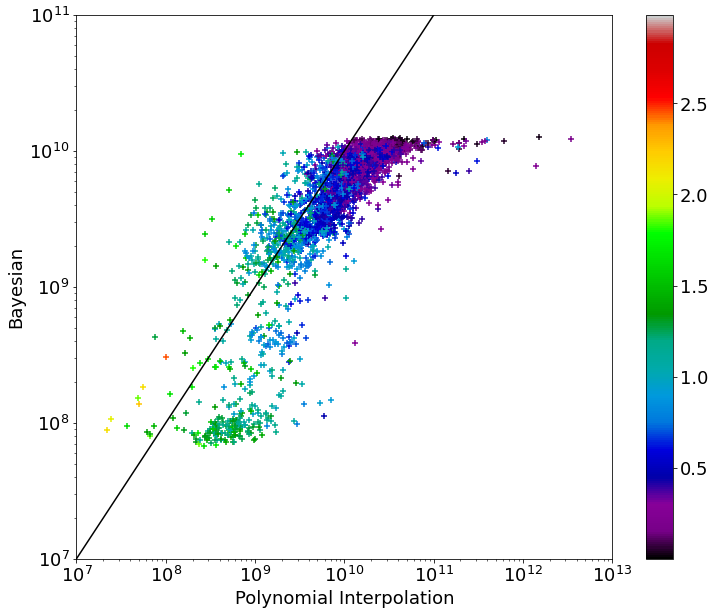

In [16]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')

In [17]:
# plt.hist(10**pdfout['P_MEAN'][pdfout_ind])

In [18]:
# plt.hist(10**np.asarray(parages)[r13_ind])

In [19]:
# plt.hist(age_dist[100])

In [21]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_dist),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

# cat.write('large_pca_ols_ages.fits',format='fits',overwrite=True)
# cat.write('TEST_pca_ols_ll.fits',format='fits',overwrite=True)

In [32]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

In [22]:
### Find all models

#transform data to new basis
# new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x0 = parsec['logTe'] #new_data[:,0]
x1 = parsec['Ksmag'] #new_data[:,1]
x2 = np.log10(parsec['Z']/0.02) #new_data[:,2]
x3 = parsec['logg']

# linear int
x01 = np.multiply(x0,x1) 
x02 = np.multiply(x0,x2)
x03 = np.multiply(x0,x3)
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x0sq = x0**2
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x0cu = x0**3
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x0','x1','x2','x3','x01','x02','x03','x12','x13','x23','x0sq','x1sq','x2sq','x3sq','x0cu','x1cu',
               'x2cu','x3xu']
all_var = [x0,x1,x2,x3,x01,x02,x03,x12,x13,x23,x0sq,x1sq,x2sq,x3sq,x0cu,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

len(models)
split_models = np.array_split(models,9)
split_models_str = np.array_split(models_str,9)

In [23]:
262143/9

29127.0

In [24]:
### Fit All Models

import statsmodels.api as sm 

mads = []
maxs = []
all_params = []
ll = []
for i in tqdm_notebook(range(len(split_models[0])),desc='Done?'):
    pmodl = np.array(split_models[0][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[1])),desc='Done?'):
    pmodl = np.array(split_models[1][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[2])),desc='Done?'):
    pmodl = np.array(split_models[2][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[3])),desc='Done?'):
    pmodl = np.array(split_models[3][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[4])),desc='Done?'):
    pmodl = np.array(split_models[4][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[5])),desc='Done?'):
    pmodl = np.array(split_models[5][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[6])),desc='Done?'):
    pmodl = np.array(split_models[6][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[7])),desc='Done?'):
    pmodl = np.array(split_models[7][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

In [ ]:
for i in tqdm_notebook(range(len(split_models[8])),desc='Done?'):
    pmodl = np.array(split_models[8][i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

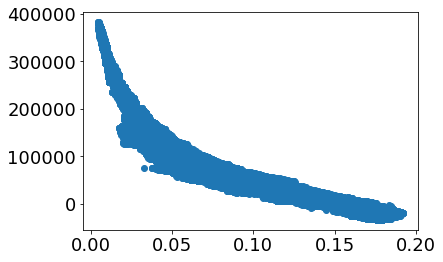

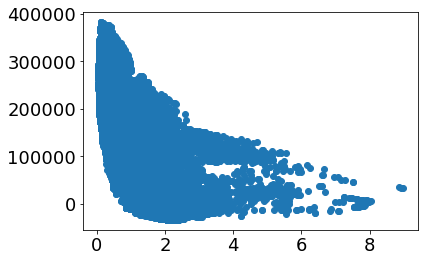

In [32]:
plt.scatter(mads,ll)
plt.show()
plt.scatter(maxs,ll)

In [38]:
print(models_str[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])

['x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x13' 'x23' 'x0sq' 'x1sq' 'x2sq' 'x3sq'
 'x0cu' 'x1cu' 'x2cu' 'x3xu']
[ 8.64520784e+02 -6.90353991e+02  4.65667481e+00 -2.03726029e+00
 -6.78345280e+00 -4.81693744e-01  7.06378027e-01 -5.09451869e-01
 -3.79976473e-02  1.88652838e+02  1.07505826e-01  2.27720589e-01
  5.30896221e-01 -1.71228538e+01 -8.78325118e-04  3.58735574e-02
  9.94692780e-03]


In [39]:
print(models_str[np.asarray(maxs).argmin()])
print(all_params[np.asarray(maxs).argmin()])

['x1' 'x2' 'x3' 'x01' 'x13' 'x2sq' 'x2cu' 'x3xu']
[ 1.82597209e+01  3.23349699e+00  3.19800180e-01 -2.54867027e+00
 -5.82745926e-01  5.45486477e-02  1.65631468e-01  2.93817272e-02
 -1.62475788e-02]


In [40]:
print(models_str[np.asarray(ll).argmax()])
print(all_params[np.asarray(ll).argmax()])

['x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x03' 'x12' 'x13' 'x23' 'x0sq' 'x1sq'
 'x2sq' 'x3sq' 'x0cu' 'x1cu' 'x2cu' 'x3xu']
[ 8.94843380e+02 -6.96537647e+02  1.88338806e+00 -5.59593977e+00
  1.57150421e+00  3.56546381e-01  1.80635222e+00 -2.56248536e+00
  4.05841381e-02 -6.01304213e-01 -1.74806505e-01  1.83251168e+02
  1.22127100e-01  2.78799920e-01  6.93699425e-01 -1.57704422e+01
 -6.38893329e-04  4.15472329e-02  8.57160604e-03]


In [41]:
def mads_age(z0,z1,z2,z3):
    #'x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x13' 'x23' 'x0sq' 'x1sq' 'x2sq' 'x3sq' 'x0cu' 'x1cu' 'x2cu' 'x3xu'
    p = [8.64520784e+02,-6.90353991e+02,4.65667481e+00,-2.03726029e+00,-6.78345280e+00,-4.81693744e-01,
         7.06378027e-01,-5.09451869e-01,-3.79976473e-02,1.88652838e+02,1.07505826e-01,2.27720589e-01,
         5.30896221e-01,-1.71228538e+01,-8.78325118e-04,3.58735574e-02,9.94692780e-03]
    age = (p[0]+
           p[1]*z0+p[2]*z1+p[3]*z2+p[4]*z3+
           p[5]*(z0*z1)+p[6]*(z0*z2)+p[7]*(z1*z3)+p[8]*(z2*z3)+
           p[9]*(z0**2)+p[10]*(z1**2)+p[11]*(z2**2)+p[12]*(z3**2)+
           p[13]*(z0**3)+p[14]*(z1**3)+p[15]*(z2**3)+p[16]*(z3**3))
    return age

def maxs_age(z0,z1,z2,z3):
    #'x1' 'x2' 'x3' 'x01' 'x13' 'x2sq' 'x2cu' 'x3xu'
    p = [1.82597209e+01,3.23349699e+00,3.19800180e-01,-2.54867027e+00,-5.82745926e-01,5.45486477e-02,
         1.65631468e-01,2.93817272e-02,-1.62475788e-02]
    age = (p[0]+
           p[1]*z1+p[2]*z2+p[3]*z3+
           p[4]*(z0*z1)+p[5]*(z1*z3)+
           p[6]*(z2**2)+
           p[7]*(z2**3)+p[8]*(z3**3))
    return age

def ll_age(z0,z1,z2,z3):
    #'x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x03' 'x12' 'x13' 'x23' 'x0sq' 'x1sq' 'x2sq' 'x3sq' 'x0cu' 'x1cu' 'x2cu' 
    #'x3xu'
    p = [8.94843380e+02,-6.96537647e+02,1.88338806e+00,-5.59593977e+00,1.57150421e+00,3.56546381e-01,
         1.80635222e+00,-2.56248536e+00,4.05841381e-02,-6.01304213e-01,-1.74806505e-01,1.83251168e+02,
         1.22127100e-01,2.78799920e-01,6.93699425e-01,-1.57704422e+01,-6.38893329e-04,4.15472329e-02,
         8.57160604e-03]
    age = (p[0]+
           p[1]*z0+p[2]*z1+p[3]*z2+p[4]*z3+
           p[5]*(z0*z1)+p[6]*(z0*z2)+p[7]*(z0*z3)+p[8]*(z1*z2)+p[9]*(z1*z3)+p[10]*(z2*z3)+
           p[11]*(z0**2)+p[12]*(z1**2)+p[13]*(z2**2)+p[14]*(z3**2)+
           p[15]*(z0**3)+p[16]*(z1**3)+p[17]*(z2**3)+p[18]*(z3**3))
    return age

In [45]:
mads_age_dist = []
maxs_age_dist = []
ll_age_dist = []

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    am = r13['ALPHA_M'][i]
    am_err = r13['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    mads_age_noise = []
    maxs_age_noise = []
    ll_age_noise = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = add_noise(am,am_err) #(x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
#         new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
        mads_age_noise.append(mads_age(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
        maxs_age_noise.append(maxs_age(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
        ll_age_noise.append(ll_age(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))

#     for l in range(len(zs)):
#         noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    mads_age_dist.append(mads_age_noise)
    maxs_age_dist.append(maxs_age_noise)
    ll_age_dist.append(ll_age_noise)

mads_parages = [] 
maxs_parages = []
ll_parages = []

mads_devs = []
maxs_devs = []
ll_devs = []
for k in tqdm_notebook(range(len(mads_age_dist))):
    
    mads_devs.append(afunc.mad(mads_age_dist[k]))
    mads_parages.append(np.median(mads_age_dist[k]))
    
    maxs_devs.append(afunc.mad(maxs_age_dist[k]))
    maxs_parages.append(np.median(maxs_age_dist[k]))
    
    ll_devs.append(afunc.mad(ll_age_dist[k]))
    ll_parages.append(np.median(ll_age_dist[k]))

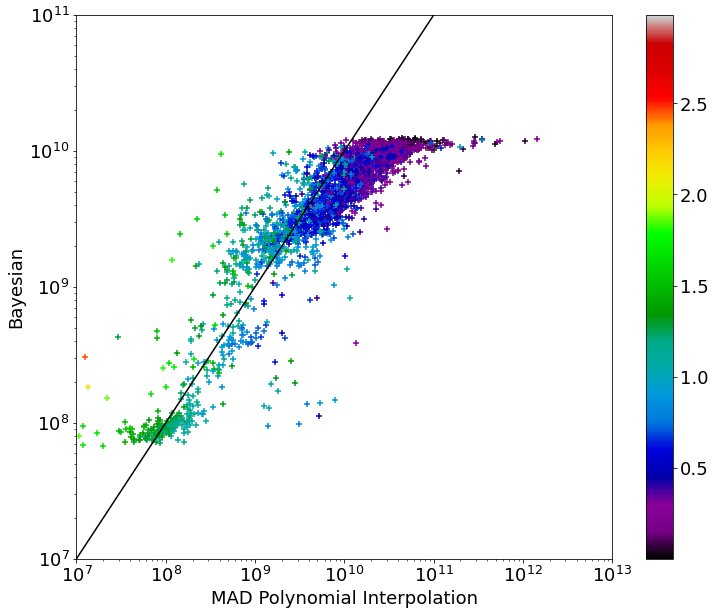

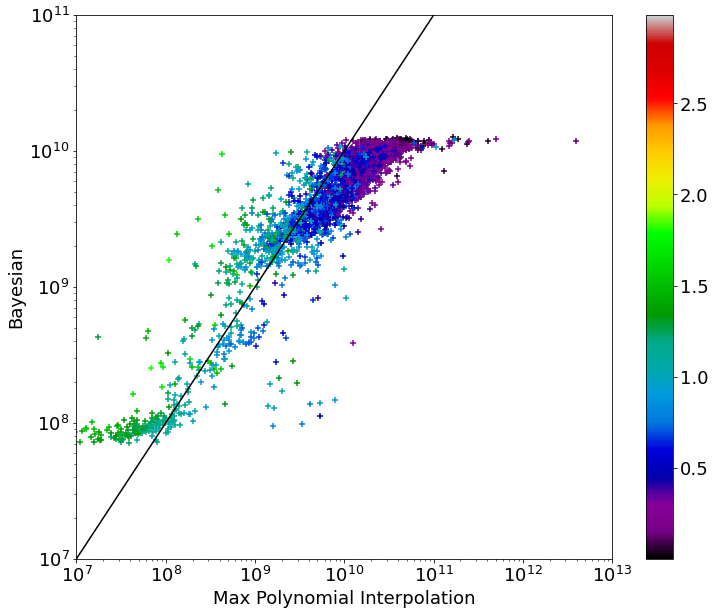

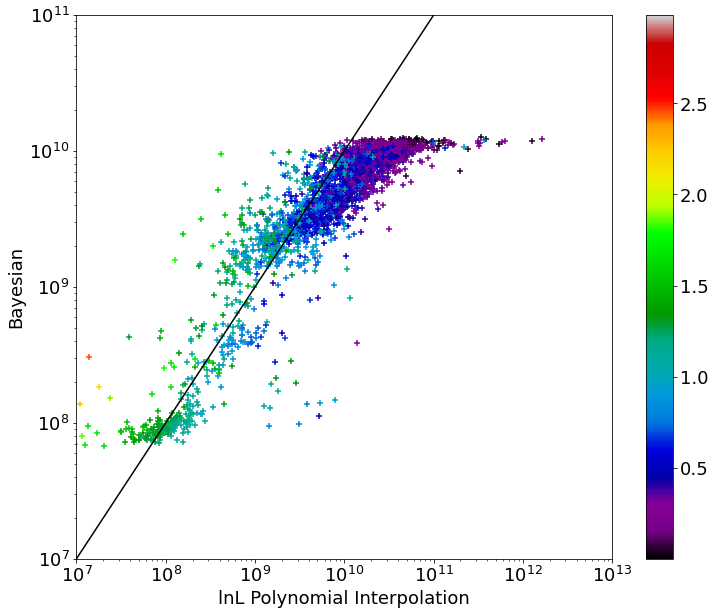

In [63]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mads_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'MAD Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

###############

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(maxs_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Max Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

###############

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'lnL Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

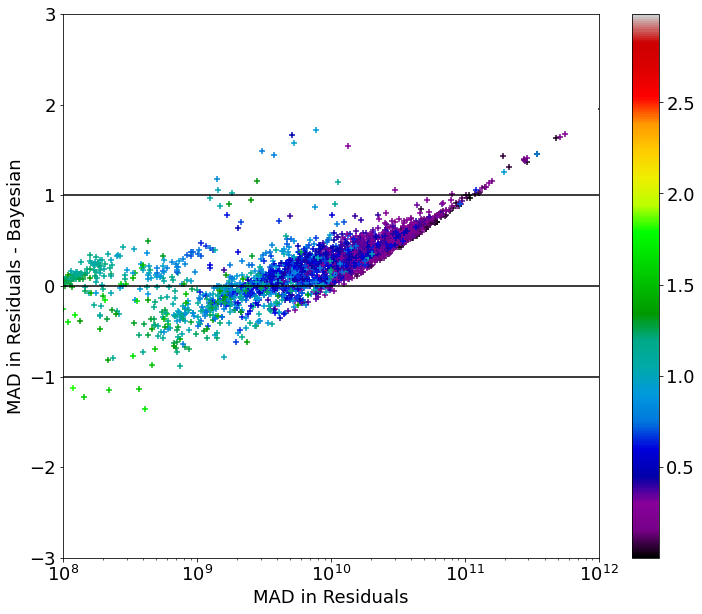

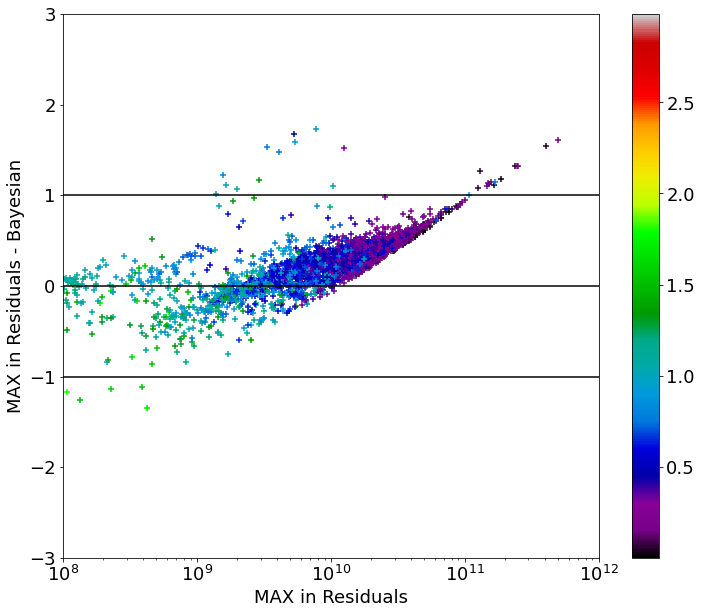

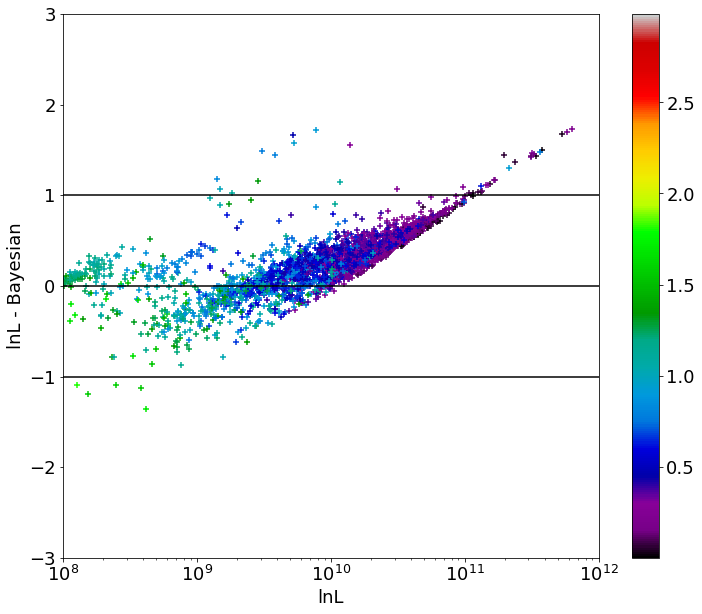

In [62]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mads_parages)[r13_ind],
            (np.asarray(mads_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=r13['LOGG'][r13_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.axhline(-1,c='k')
plt.axhline(1,c='k')

plt.colorbar()
plt.xscale('log')
plt.ylim(-3,3)
plt.xlim(10**8,10**12)

plt.ylabel(r'''MAD in Residuals - Bayesian''')
plt.xlabel(r'''MAD in Residuals''')
plt.show()

##########
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(maxs_parages)[r13_ind],
            (np.asarray(maxs_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=r13['LOGG'][r13_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.axhline(-1,c='k')
plt.axhline(1,c='k')

plt.colorbar()
plt.xscale('log')
plt.ylim(-3,3)
plt.xlim(10**8,10**12)

plt.ylabel(r'''MAX in Residuals - Bayesian''')
plt.xlabel(r'''MAX in Residuals''')
plt.show()

##########
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages)[r13_ind],
            (np.asarray(ll_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=r13['LOGG'][r13_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.axhline(-1,c='k')
plt.axhline(1,c='k')

plt.colorbar()
plt.xscale('log')
plt.ylim(-3,3)
plt.xlim(10**8,10**12)

plt.ylabel(r'''lnL - Bayesian''')
plt.xlabel(r'''lnL''')
plt.show()

In [67]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_mads_age = Column(np.asarray(mads_parages),name='MAD_AGE')
col_mads_dev = Column(np.asarray(mads_devs),name='MAD_AGE_ERR')
col_maxs_age = Column(np.asarray(maxs_parages),name='MAX_AGE')
col_maxs_dev = Column(np.asarray(maxs_devs),name='MAX_AGE_ERR')
col_ll_age = Column(np.asarray(ll_parages),name='ll_AGE')
col_ll_dev = Column(np.asarray(ll_devs),name='ll_AGE_ERR')

cat.add_column(col_id)
cat.add_column(col_mads_age)
cat.add_column(col_mads_dev)
cat.add_column(col_maxs_age)
cat.add_column(col_maxs_dev)
cat.add_column(col_ll_age)
cat.add_column(col_ll_dev)

# cat.write('largeparsec_ages.fits',format='fits')#,overwrite=True)